In [4]:
# Cell 1
import os
import numpy as np
import pandas as pd
import joblib
import mlflow

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

import sys
sys.path.append(os.path.abspath(".."))
from src.utils import load_json, save_json
from src.metrics import multiclass_and_binary_metrics

mlflow.set_experiment("iml2025_project")
os.makedirs("../models", exist_ok=True)
os.makedirs("../logs/metrics", exist_ok=True)

# load train/test and class_list
train = pd.read_csv("../data/train_fe.csv")
train["class2"] = (train["class4"] != "nonevent").astype(int)
X_train = train.drop(columns=["class4","class2"])
y_class4 = train["class4"].values
y_binary = train["class2"].values

test = pd.read_csv("../data/test_fe.csv")
X_test = test.drop(columns=["id"])

class_list = load_json("../models/class_list.json")
label_to_idx = {lab:i for i,lab in enumerate(class_list)}
nonevent_idx = label_to_idx["nonevent"]


2025/12/07 15:09:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/07 15:09:05 INFO mlflow.store.db.utils: Updating database tables
2025/12/07 15:09:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 15:09:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/07 15:09:05 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/07 15:09:05 INFO alembic.runtime.migration: Will assume non-transactional DDL.


In [5]:
# Cell 2 - Load ensemble weights and ensemble OOF multiclass raw
ens_meta = load_json("../models/ensemble_weights.json")
model_names = ens_meta["model_names"]
weights = np.array(ens_meta["weights"])
print("Ensemble models & weights:", list(zip(model_names, weights)))

ens_oof_raw = np.load("../models/oof_ensemble_multiclass_raw.npy")  # (n_train, k)
# derive raw p_event OOF
oof_p_event_raw = 1.0 - ens_oof_raw[:, nonevent_idx]
np.save("../models/oof_ensemble_p_event_raw.npy", oof_p_event_raw)


Ensemble models & weights: [('extratrees', np.float64(0.346139489603939)), ('xgb', np.float64(0.6537253435206948)), ('rf', np.float64(0.00013516687536620057))]


**Calibration Curve - Before Calibration**

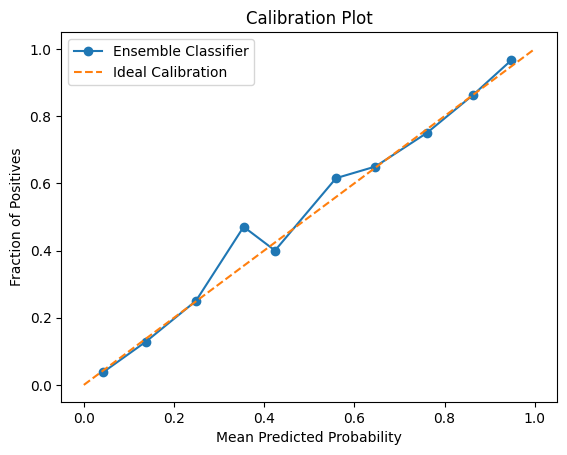

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_binary, oof_p_event_raw, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label = 'Ensemble Classifier')
plt.plot([0, 1], [0, 1], '--', label = 'Ideal Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend(loc = 'upper left')
plt.savefig('../logs/eda_plots/calibration_plot_ensemble_not_calibrated.png')
plt.show()


In [5]:
# Cell 3 - Fit Platt calibrator on OOF p_event (binary only)
with mlflow.start_run(run_name="06_platt_calibration_binary"):
    calibrator = LogisticRegression(max_iter=2000)
    calibrator.fit(oof_p_event_raw.reshape(-1,1), y_binary)
    joblib.dump(calibrator, "../models/calibrator_platt_p_event.joblib")

    oof_p_event_cal = calibrator.predict_proba(oof_p_event_raw.reshape(-1,1))[:,1]
    bin_logloss_cal = log_loss(y_binary, oof_p_event_cal)
    bin_acc_cal = accuracy_score(y_binary, (oof_p_event_cal > 0.5).astype(int))
    mlflow.log_metric("bin_logloss_oof_calibrated", float(bin_logloss_cal))
    mlflow.log_metric("bin_accuracy_oof_calibrated", float(bin_acc_cal))
    save_json({"bin_logloss_oof_calibrated": float(bin_logloss_cal), "bin_accuracy_oof_calibrated": float(bin_acc_cal)}, "../models/calibration_platt_metrics.json")
    print("OOF binary logloss after Platt:", bin_logloss_cal, "acc:", bin_acc_cal)


OOF binary logloss after Platt: 0.32977921968787743 acc: 0.8688888888888889


**Calibration Curve - After Calibration**

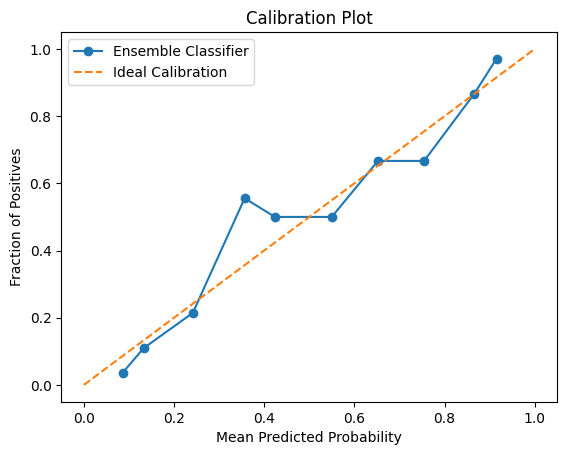

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_binary, oof_p_event_cal, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label = 'Ensemble Classifier')
plt.plot([0, 1], [0, 1], '--', label = 'Ideal Calibration')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend(loc = 'upper left')
plt.savefig('../logs/eda_plots/calibration_plot_ensemble_calibrated.png')
plt.show()


In [7]:
# Cell 4
# load trained full models (from Notebook 4)
# model_names: ["extratrees","xgb","rf"] (ordered)
models = []
for name in model_names:
    path = f"../models/best_{('ex' if name=='extratrees' else name)}_full.joblib"
    # note: ExtraTrees used key "best_extratrees_full.joblib" in Notebook 4; others similar
    # Try to handle possible naming differences robustly:
    if name == "extratrees":
        path = "../models/best_extratrees_full.joblib"
    elif name == "xgb":
        path = "../models/best_xgb_full.joblib"
    elif name == "rf":
        path = "../models/best_rf_full.joblib"
    if not os.path.exists(path):
        raise FileNotFoundError(f"Expected model file not found: {path}")
    models.append(joblib.load(path))

print("Loaded models:", [type(m).__name__ for m in models])


Loaded models: ['ExtraTreesClassifier', 'XGBClassifier', 'RandomForestClassifier']


In [8]:
# Cell 5 - Predict test multiclass probs per model and ensemble
probs_list_test = [m.predict_proba(X_test) for m in models]   # list of (n_test, k)
# Weighted average (order must match model_names & weights)
probs_test_ens_raw = sum(weights[i] * probs_list_test[i] for i in range(len(probs_list_test)))
# normalize rows (numerical safety)
probs_test_ens_raw = probs_test_ens_raw / probs_test_ens_raw.sum(axis=1, keepdims=True)
np.save("../models/probs_test_ensemble_raw.npy", probs_test_ens_raw)


In [9]:
# Cell 6 - Derive p_event_test_raw and apply Platt calibrator (binary only)
p_nonevent_test_raw = probs_test_ens_raw[:, nonevent_idx]
p_event_test_raw = 1.0 - p_nonevent_test_raw

calibrator = joblib.load("../models/calibrator_platt_p_event.joblib")
p_event_test_cal = calibrator.predict_proba(p_event_test_raw.reshape(-1,1))[:,1]
np.save("../models/p_event_test_calibrated.npy", p_event_test_cal)


In [10]:
# Cell 7 - Determine class4 submission label from raw ensemble multiclass (argmax) and build submission
# class4 by argmax on raw ensemble multiclass probabilities (not modified by binary calibrator)
class4_idx = np.argmax(probs_test_ens_raw, axis=1)
# convert indices to string labels using the original class_list order and LabelEncoder mapping:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(class_list)   # must be same order as earlier
class4_labels = le.inverse_transform(class4_idx)

submission = pd.DataFrame({
    "id": test["id"],
    "class4": class4_labels,
    "p": p_event_test_cal
})
submission_path = "../data/submission_calibrated.csv"
submission.to_csv(submission_path, index=False)
mlflow.log_artifact(submission_path)
print("Saved submission to:", submission_path)
submission.head()


Saved submission to: ../data/submission_calibrated.csv


,id,class4,p
0,450,nonevent,0.555490
1,451,II,0.895587
2,452,nonevent,0.077709
3,453,nonevent,0.644476
4,454,Ib,0.899344


In [11]:
submission = pd.DataFrame({
    "id": test["id"],
    "class4": class4_labels,
    "p": p_event_test_raw
})
submission_path = "../data/submission_not_calibrated.csv"
submission.to_csv(submission_path, index=False)
mlflow.log_artifact(submission_path)
print("Saved submission to:", submission_path)
submission.head()

Saved submission to: ../data/submission_not_calibrated.csv


,id,class4,p
0,450,nonevent,0.535253
1,451,II,0.908673
2,452,nonevent,0.012460
3,453,nonevent,0.607362
4,454,Ib,0.916590


In [12]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(".."))
from src.metrics import get_aggregated_score

et_aggregated_score = get_aggregated_score(0.866667, 0.660000, 1.402295)
xgb_aggregated_score = get_aggregated_score(0.866667, 0.684444, 1.376222)
rf_aggregated_score = get_aggregated_score(0.860000, 0.633333, 1.410922)
ensemble_aggregated_score = get_aggregated_score(0.8711111111111111, 0.6777777777777778, 1.3759060730812251)

perplexity_after_calibration = float(np.exp(0.32977921968787743))
print("Perplexity after calibration:", perplexity_after_calibration)
calibrated_aggregated_score = get_aggregated_score(0.8688888888888889, 0.6777777777777778, perplexity_after_calibration)
print("Aggregated Scores:")
print(f"ExtraTrees: {et_aggregated_score:.6f}")
print(f"XGBoost: {xgb_aggregated_score:.6f}")
print(f"RandomForest: {rf_aggregated_score:.6f}")
print(f"Ensemble (not calibrated): {ensemble_aggregated_score:.6f}")
print(f"Ensemble (calibrated): {calibrated_aggregated_score:.6f}")

Perplexity after calibration: 1.3906610639843686
Aggregated Scores:
ExtraTrees: 0.708124
XGBoost: 0.724963
RandomForest: 0.694137
Ensemble (not calibrated): 0.724328
Ensemble (calibrated): 0.718669
